
[Scanpy Clustering Tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

Get Data:

```
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write 
```

32k genes, 2700 Samples. matrix.mtx sparse integer matrix.

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.6.0 pandas==1.2.0 scikit-learn==0.24.1 statsmodels==0.12.2


Note I am missing some stuff found in the tutorial:

umap==0.4.2 python-igraph==0.7.1 leidenalg==0.7.0

In [39]:
results_file = 'pbmc3k.h5ad'  # the file that will store the analysis results


In [5]:
import anndata
import scipy.io
from pathlib import Path
DATA=Path("data/filtered_gene_bc_matrices/hg19")
a_data = anndata.AnnData(
    X=scipy.io.mmread(DATA/"matrix.mtx").T, 
    obs=pd.read_csv(DATA/"barcodes.tsv", sep = '\t', header=None), 
    var=pd.read_csv(DATA/"genes.tsv", sep = '\t', header=None, index_col=1, names=['gene_ids'])
)
# help(sc.read_10x_mtx)
a2_data = sc.read_10x_mtx(DATA, var_names='gene_symbols',cache=True)
assert (a2_data.X - a_data.X).sum() == 0

a_data.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
a2_data.var_names_make_unique()
assert set(list(a_data.var.index))==set(list(a2_data.var.index))

/Users/jsteill/bin/Virt_Py_Envs/jlab2/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


normalizing counts per cell
    finished (0:00:00)


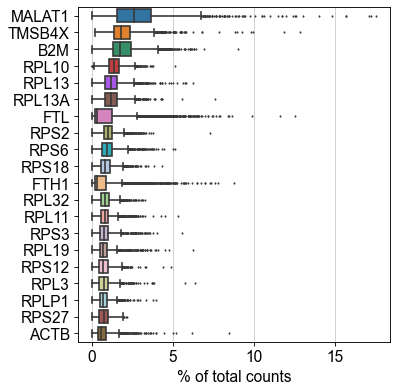

In [6]:
sc.pl.highest_expr_genes(a2_data, n_top=20, )

In [7]:
# Filter out samples which express less than 200 genes, and genes expressed in fewer than 3 cells.
print(a2_data.shape)
sc.pp.filter_cells(a2_data, min_genes=200)
sc.pp.filter_genes(a2_data, min_cells=3)
print(a2_data.shape)

filtered out 19024 genes that are detected in less than 3 cells


(2700, 32738)
(2700, 13714)


In [8]:
#Let’s assemble some information about mitochondrial genes, which are important for quality control.

#Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

#High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.
#With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

# Annotate the mitochrondrial genes with a boolean in var.mt
a2_data.var['mt_me'] = list(map(lambda x:x.startswith('MT-'), a2_data.var.index))
a2_data.var['mt'] = a2_data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
#print(list(map(lambda x:x.startswith('MT-'), a2_data.var.index)))
assert (a2_data.var['mt_me'] == a2_data.var['mt']).all()


# https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.calculate_qc_metrics.html

sc.pp.calculate_qc_metrics(a2_data, qc_vars = ['mt'], percent_top=None, log1p=False, inplace=True)


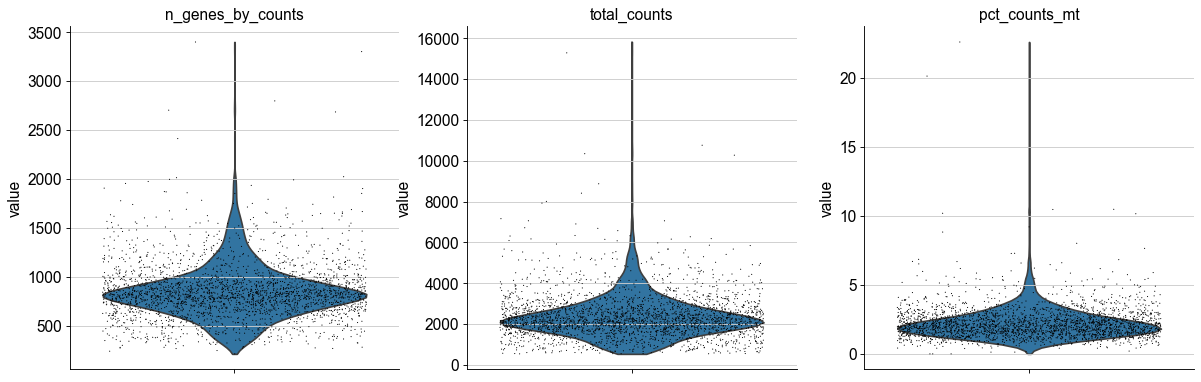

In [9]:
sc.pl.violin(a2_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [10]:
# x axis is cell-ordered, not significant.
# n_genes_by_counts - number of genes in a cell with at least one count. ??

a2_data.obs.describe()





,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,846.994074,845.546667,2365.376953,50.806667,2.216642
std,282.104964,281.347923,1093.378784,30.891550,1.166708
min,212.000000,212.000000,546.000000,0.000000,0.000000
25%,690.000000,690.000000,1755.750000,31.000000,1.537264
50%,817.000000,816.000000,2196.000000,44.000000,2.030800
75%,953.250000,952.000000,2762.250000,62.000000,2.643177
max,3422.000000,3400.000000,15818.000000,347.000000,22.569027


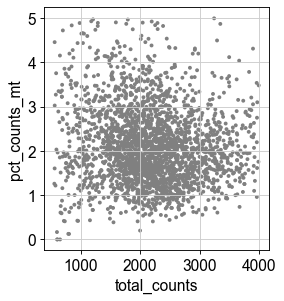

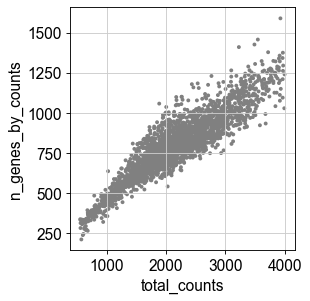

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,803.668699,802.361382,2186.728516,45.379269,2.104817
std,197.946513,197.659242,699.166748,22.455297,0.850138
min,212.000000,212.000000,556.000000,0.000000,0.000000
25%,686.750000,686.000000,1745.000000,30.000000,1.508604
50%,807.000000,805.000000,2160.000000,42.000000,1.982727
75%,923.000000,922.000000,2625.000000,57.000000,2.577741
max,1597.000000,1589.000000,3994.000000,168.000000,4.993834


In [11]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:
adata = a2_data[a2_data.obs.pct_counts_mt < 5.0, :]
adata = adata[adata.obs.total_counts < 4000, :]
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
adata.obs.describe()

In [12]:
# Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.`
# Logarithmize the data

sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)



/Users/jsteill/bin/Virt_Py_Envs/jlab2/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


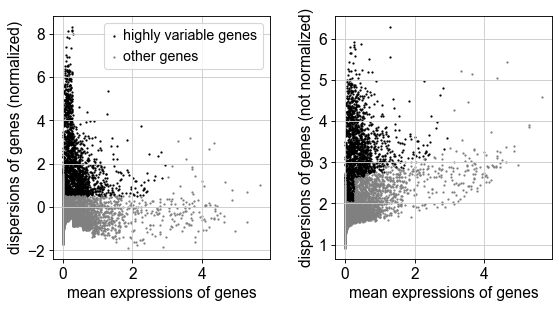

In [20]:
# Identify highly variable genes and plot
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [21]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized 
# raw gene expression for later use in differential testing and visualizations of 
# gene expression. This simply freezes the state of the AnnData object.
#
# You can get back an AnnData of the object in .raw by calling .raw.to_adata().
adata.raw = adata

In [22]:
# Filter only highly_variable.
# Regress out effects of total counts per cell and the percentage of mitochondrial genes
# Scale genes to unit variance, clip values exceeding 10Sds

adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


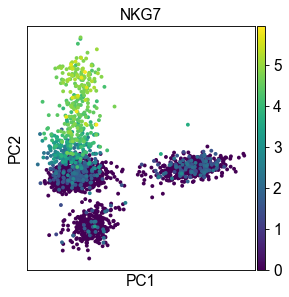

In [36]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='NKG7') # CST3 is a gene

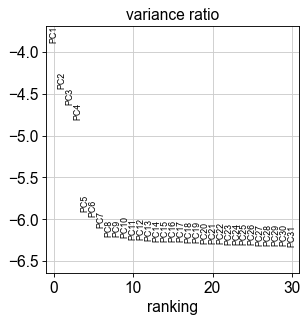

In [37]:
# How many PCs do we need to keep for other methods?
sc.pl.pca_variance_ratio(adata, log=True)

In [40]:
adata.write(results_file) 